In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing the required libraries**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import auc, roc_auc_score,roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

**Plotly Visualization setup**

In [30]:
!pip install plotly --upgrade

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode,plot,iplot
  import plotly.graph_objs as go
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=True)

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)


**Loading the data**

In [0]:
#Train dataset
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Loan-Prediction/data/train.csv')
#Test dataset
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Loan-Prediction/data/test.csv')

**Summarizing the data**

In [32]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


**Finding the dimensions of the Data**

In [33]:
df_train.shape
df_test.shape

(367, 12)

**Statistical summary of all attributes**

In [34]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


**Class distribution of the Data**

In [35]:
df_train.groupby('Loan_Status').size()

Loan_Status
N    192
Y    422
dtype: int64

**Feature Engineering**

In [0]:
#Removing of missing values
df_train.dropna(inplace = True)

In [37]:
df_train.drop('Loan_ID', axis =1, inplace =True)
df_train.isnull().sum()
df_train.shape

(480, 12)

In [0]:
df_train['Dependents'].replace('3+', 3, inplace = True)

In [0]:
#Encoding the data
def encoded_data(df):
  le = LabelEncoder()
  df['Gender'] = le.fit_transform(df.Gender)
  df['Married'] = le.fit_transform(df.Gender)
  df['Education'] = le.fit_transform(df.Education)
  df['Self_Employed'] = le.fit_transform(df.Self_Employed) 
  df['Property_Area'] = le.fit_transform(df.Property_Area)
  df['Loan_Status'] = le.fit_transform(df.Loan_Status)
  
  return df.head()

In [40]:
encoded_data(df_train)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,1,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
5,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1


In [41]:
df_train['Dependents'] =df_train.Dependents.astype(int)
df_train['Education'] =df_train.Education.astype(int)
df_train['Self_Employed'] =df_train.Self_Employed.astype(int)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 1 to 613
Data columns (total 12 columns):
Gender               480 non-null int64
Married              480 non-null int64
Dependents           480 non-null int64
Education            480 non-null int64
Self_Employed        480 non-null int64
ApplicantIncome      480 non-null int64
CoapplicantIncome    480 non-null float64
LoanAmount           480 non-null float64
Loan_Amount_Term     480 non-null float64
Credit_History       480 non-null float64
Property_Area        480 non-null int64
Loan_Status          480 non-null int64
dtypes: float64(4), int64(8)
memory usage: 48.8 KB


**Visualising the Data**

**a) Plotting Univariate plots**

In [54]:
enable_plotly_in_cell()
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y = df_train['ApplicantIncome'], boxpoints='all', jitter=0.3, pointpos=-1.8, name='ApplicantIncome'),row=1, col=1)

fig.add_trace(go.Box(y = df_train['CoapplicantIncome'], boxpoints='all', jitter=0.3, pointpos=-1.8,name='CoapplicantIncome' ),row=1, col=2)

fig.add_trace(go.Box(y = df_train['LoanAmount'], boxpoints='all', jitter=0.3, pointpos=-1.8, name='LoanAmount'),row=1, col=3)

iplot(fig, filename = 'train')

In [43]:
df_train.dtypes

Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object

**Training and Evaluating our models**



> **a) Splitting the training and testing data**



In [0]:
y = df_train['Loan_Status'].values 
X = df_train.drop('Loan_Status', axis = 1).values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)



> **b) Building and Cross-Validating the model**



In [45]:
algorithms = [] 
scores = [] 
names = [] 
  
algorithms.append(('Logisitic Regression', LogisticRegression(solver= 'lbfgs', max_iter=1000))) 
algorithms.append(('KNN', KNeighborsClassifier())) 
algorithms.append(('Decision Tree', DecisionTreeClassifier())) 
algorithms.append(('Random Forest', RandomForestClassifier()))
  
for name, algo in algorithms: 
    k_fold = KFold(n_splits = 10, random_state = 0) 
  
    # Applying k-cross validation 
    cvResults = cross_val_score(algo, X_train, y_train, cv = k_fold, scoring ='accuracy') 
  
    scores.append(cvResults) 
    names.append(name)
    print(str(name)+' : '+str(cvResults.mean()))

Logisitic Regression : 0.8111111111111111
KNN : 0.6722222222222223
Decision Tree : 0.7194444444444443
Random Forest : 0.7916666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will chan



> **c) Visually comparing the results of the different algorithms**



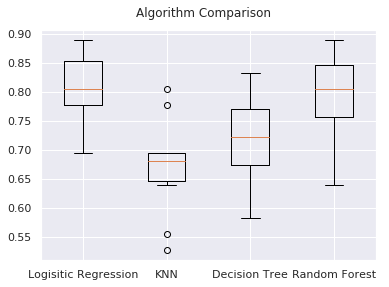

In [46]:
fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(scores) 
plt.subplots_adjust(wspace = 1, hspace = 0.2, left  = 0.125, right = 0.9, bottom = 0.1, top = 0.9)
ax.set_xticklabels(names) 
plt.show() 


 **Making predictions and evaluating the predicitons**





> **Hyperparameter tuning**


        1. GridSearchCV
        2. RandomizedSearchCV





In **GridSearchCV** approach, machine learning model is evaluated for a range of hyperparameter values. This approach is called GridSearchCV, because it searches for best set of hyperparameters from a grid of hyperparameters values.

**Drawback** : GridSearchCV will go through all the intermediate combinations of hyperparameters which makes grid search computationally very expensive.

**RandomizedSearchCV**
solves the drawbacks of GridSearchCV, as it goes through only a fixed number of hyperparameter settings. It moves within the grid in random fashion to find the best set hyperparameters. This approach reduces unnecessary computation.





> **i: Decision Tree Algo**







> **Hyperparameter tuning using RandomizedSearchCV**



In [47]:
#RandomizedSearchCV
# Necessary imports 
from scipy.stats import randint 
from sklearn.model_selection import RandomizedSearchCV 

# Creating the hyperparameter grid 
param_dist = {"max_depth": [3, None], 
			"max_features": randint(1, 9), 
			"min_samples_leaf": randint(1, 9), 
			"criterion": ["gini", "entropy"]} 

# Instantiating Decision Tree classifier 
tree = DecisionTreeClassifier() 

# Instantiating RandomizedSearchCV object 
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 10) 

tree_cv.fit(X_train, y_train) 

# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_)) 


Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 1}
Best score is 0.7916666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [48]:
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, max_features = 7, min_samples_leaf= 3)
bc = BaggingClassifier(dt, n_estimators=10, max_samples=0.6, max_features=1.0, bootstrap=True, bootstrap_features=False)
bc.fit(X_train, y_train)
print('Decision_bagging_score: %0.2f%%' %(bc.score(X_test, y_test)*100))

Decision_bagging_score: 78.33%


**ii: LogisticRegression** 




> **Hyperparameter tuning using GridSearchCV**



In [49]:
# Necessary imports 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV 

# Creating the hyperparameter grid 
c_space = np.logspace(-5, 8, 15) 
param_grid = {'C': c_space} 

# Instantiating logistic regression classifier 
logreg = LogisticRegression(solver= 'lbfgs', max_iter=1000) 

# Instantiating the GridSearchCV object 
logreg_cv = GridSearchCV(logreg, param_grid, cv = 10) 

logreg_cv.fit(X_train, y_train) 

# Print the tuned parameters and score 
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_)) 


Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.8111111111111111


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [50]:
lr = LogisticRegression(C=0.4393970560760795, solver= 'lbfgs', max_iter=1000)
bc = BaggingClassifier(lr, n_estimators=10, max_samples=0.6, max_features=1.0, bootstrap=True, bootstrap_features=False)
bc.fit(X_train, y_train)
print('Logistic_Bagging_Score: %0.2f%% ' %(bc.score(X_test, y_test)*100))


Logistic_Bagging_Score: 77.50% 


**iii. KNN**



> **Hyperparameter tuning using GridSearchCV**



In [51]:
# Instantiating logistic regression classifier 
knn = KNeighborsClassifier() 

# Creating the hyperparameter grid 
k_range = list(range(1, 51))
param_grid = {'n_neighbors':k_range } 

# Instantiating the GridSearchCV object 
knn_cv = GridSearchCV(knn, param_grid, cv = 10) 

knn_cv.fit(X_train, y_train) 

# Print the tuned parameters and score 
print("Tuned knn Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_)) 


Tuned knn Parameters: {'n_neighbors': 11}
Best score is 0.7083333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



[0.6213728013728013, 0.5547425997425998, 0.655812955812956, 0.6114135564135564, 0.6724088374088375, 0.6526426426426426, 0.6948026598026598, 0.6781274131274131, 0.691866151866152, 0.6807507507507508, 0.7086164736164736, 0.688929643929644, 0.7056799656799656, 0.6975718575718576, 0.6891591591591592, 0.6808215358215358, 0.6836786786786787, 0.6863813813813814, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557, 0.7056842556842557]


Text(0, 0.5, 'Cross-Validation Accuracy')

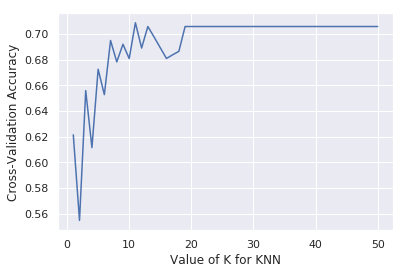

In [53]:
#search for an optimal value of K for KNN
k_score = []
for k in range(1,51):
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    k_score.append(scores.mean())
print (k_score)

#plot the value of K for KNN versus the Cross-Validation accuracy
k_range = range(1,51)
plt.plot(k_range , k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validation Accuracy')